In [658]:
!pip install hnswlib polars  --quiet
!pip install shap gradio --quiet

In [659]:
# Suppress warnings
import re
import warnings

import gradio as gr
import hnswlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
import shap
import xgboost as xgb
from scipy.spatial import distance
from sklearn.datasets import load_breast_cancer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

# Suppress warnings
warnings.filterwarnings("ignore")

In [660]:
# Use alternative encoding to avoid UnicodeDecodeError
df = pl.read_csv('../data/fy2022_archived_opportunities.csv', encoding='latin-1')
# Get the first 85000 rows
df = df.tail(15000)

In [661]:
# Function to clean column names
def clean_names(df):
    """
    Cleans column names of a Polars DataFrame by removing special characters,
    converting to lowercase, and replacing spaces with underscores.

    Args:
        df: Polars DataFrame

    Returns:
        Polars DataFrame with cleaned column names.
    """
    df.columns = [re.sub(r'\W+', '_', col).lower() for col in df.columns]
    return df

# Load your DataFrame
# df2023 = pl.read_csv('your_dataset.csv')  # Replace with your actual data loading method

# Clean column names
df2022 = clean_names(df)
df2022

noticeid,title,sol_,department_ind_agency,cgac,sub_tier,fpds_code,office,aac_code,posteddate,type,basetype,archivetype,archivedate,setasidecode,setaside,responsedeadline,naicscode,classificationcode,popstreetaddress,popcity,popstate,popzip,popcountry,active,awardnumber,awarddate,award_,awardee,primarycontacttitle,primarycontactfullname,primarycontactemail,primarycontactphone,primarycontactfax,secondarycontacttitle,secondarycontactfullname,secondarycontactemail,secondarycontactphone,secondarycontactfax,organizationtype,state,city,zipcode,countrycode,additionalinfolink,link,description
str,str,str,str,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""a70821cd74174f6ab973bd08c6a7ee…","""J065--Surgical Instrument Main…","""36C24222Q0070""","""VETERANS AFFAIRS, DEPARTMENT O…",36,"""VETERANS AFFAIRS, DEPARTMENT O…","""3600""","""242-NETWORK CONTRACT OFFICE 02…","""36C242""","""2021-10-24 23:12:17.801-04""","""Presolicitation""","""Presolicitation""","""autocustom""","""2022-01-08""","""SDVOSBC""","""Service-Disabled Veteran-Owned…","""2021-11-09T10:00:00-05:00""","""811219""","""J065""","""Department of Veterans Affairs…","""New York""","""NY""","""10010""","""USA""","""No""","""""","""""","""""","""null ""","""Contracting Officer""","""Janice Brooks Campbell""","""Janice.Brooks@va.gov""","""(718) 584-9000 x6096""","""""","""""","""""","""""","""""","""""","""OFFICE""","""NY""","""ALBANY""","""12208""","""USA""","""""","""https://sam.gov/opp/a70821cd74…","""Solicitation will be posted wi…"
"""e71fbe994ace45879dd2df6be9faf8…","""Little Rock, AR - Recruiting L…","""W1927REACQ5""","""DEPT OF DEFENSE""",21,"""DEPT OF THE ARMY""","""2100""","""US ARMY ENGINEER DISTRICT LITT…","""W9127S""","""2021-10-24 22:49:59.087-04""","""Sources Sought""","""Sources Sought""","""autocustom""","""2021-11-08""","""""","""""","""2021-11-08T12:00:00-06:00""","""""","""""","""""","""Little Rock""","""AR""","""72205""","""USA""","""No""","""""","""""","""""","""""","""""","""LaTasha Rideout""","""latasha.l.rideout@usace.army.m…","""5013245878""","""""","""""","""""","""""","""""","""""","""OFFICE""","""AR""","""LITTLE ROCK""","""72201-3225""","""USA""","""""","""https://sam.gov/opp/e71fbe994a…","""The U.S. Government currently …"
"""8615d49c020f40d89fe9c1a7bdd827…","""Little Rock, AR - Medical Recr…","""W9127REACQ4""","""DEPT OF DEFENSE""",21,"""DEPT OF THE ARMY""","""2100""","""US ARMY ENGINEER DISTRICT LITT…","""W9127S""","""2021-10-24 22:38:43.932-04""","""Sources Sought""","""Sources Sought""","""autocustom""","""2021-11-08""","""""","""""","""2021-11-08T12:00:00-06:00""","""""","""""","""""","""Little Rock""","""AR""","""72205""","""USA""","""No""","""""","""""","""""","""""","""""","""LaTasha Rideout""","""latasha.l.rideout@usace.army.m…","""5013245878""","""""","""""","""""","""""","""""","""""","""OFFICE""","""AR""","""LITTLE ROCK""","""72201-3225""","""USA""","""""","""https://sam.gov/opp/8615d49c02…","""The U.S. Government currently …"
"""df6795ad948e473b8af0fcbb0c7d4a…","""Jonesboro, AR - Recruiting Lea…","""W1927REACQ3""","""DEPT OF DEFENSE""",21,"""DEPT OF THE ARMY""","""2100""","""US ARMY ENGINEER DISTRICT LITT…","""W9127S""","""2021-10-24 22:28:25.543-04""","""Sources Sought""","""Sources Sought""","""autocustom""","""2021-11-08""","""""","""""","""2021-11-08T12:00:00-06:00""","""""","""""","""""","""Jonesboro""","""AR""","""72401""","""USA""","""No""","""""","""""","""""","""""","""""","""LaTasha Rideout""","""latasha.l.rideout@usace.army.m…","""5013245878""","""""","""""","""""","""""","""""","""""","""OFFICE""","""AR""","""LITTLE ROCK""","""72201-3225""","""USA""","""""","""https://sam.gov/opp/df6795ad94…","""The U.S. Government currently …"
"""4b1ec557da8d434a9a5ddd771f5602…","""25--CROWFOOT 36MM""","""SPE7L322U0297""","""DEPT OF DEFENSE""",97,"""DEFENSE LOGISTICS AGENCY (DLA)""","""97AS""","""DLA LAND AND MARITIME"

In [662]:
# Calculate the number of unique values and missing values for each column
summary = pl.DataFrame({
    'column': df2022.columns,
    'unique_values': [df2022[col].n_unique() for col in df2022.columns],
    'missing_values': [df2022[col].null_count() for col in df2022.columns]
})

# Display the summary
print(summary)

shape: (47, 3)
┌───────────────────────┬───────────────┬────────────────┐
│ column                ┆ unique_values ┆ missing_values │
│ ---                   ┆ ---           ┆ ---            │
│ str                   ┆ i64           ┆ i64            │
╞═══════════════════════╪═══════════════╪════════════════╡
│ noticeid              ┆ 15000         ┆ 0              │
│ title                 ┆ 9350          ┆ 0              │
│ sol_                  ┆ 12090         ┆ 0              │
│ department_ind_agency ┆ 53            ┆ 0              │
│ cgac                  ┆ 53            ┆ 1              │
│ …                     ┆ …             ┆ …              │
│ zipcode               ┆ 743           ┆ 0              │
│ countrycode           ┆ 29            ┆ 0              │
│ additionalinfolink    ┆ 1             ┆ 0              │
│ link                  ┆ 15000         ┆ 0              │
│ description           ┆ 10980         ┆ 0              │
└───────────────────────┴───────────────┴

In [663]:
# List of categorical columns
categorical_cols = ['title', 'sol_', 'department_ind_agency', 'sub_tier', 'fpds_code', 'office',
                     'aac_code', 'posteddate', 'type', 'basetype', 'archivetype', 'archivedate', 
                     'setasidecode', 'setaside', 'responsedeadline', 'naicscode', 'classificationcode', 
                     'popstreetaddress', 'popcity', 'popstate', 'popzip', 'popcountry', 'awardnumber',
                     'awarddate', 'awardee', 'state', 'city', 'zipcode', 'countrycode', 'description']

# Convert all categorical columns to strings
df2022 = df2022.with_columns([pl.col(col).cast(pl.Utf8) for col in categorical_cols])

In [664]:
# Apply LabelEncoder to each categorical column
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df2022 = df2022.with_columns([pl.Series(col, le.fit_transform(df2022[col].to_list()))])
    label_encoders[col] = le

# Ensure numerical columns are in the correct format

df2022

noticeid,title,sol_,department_ind_agency,cgac,sub_tier,fpds_code,office,aac_code,posteddate,type,basetype,archivetype,archivedate,setasidecode,setaside,responsedeadline,naicscode,classificationcode,popstreetaddress,popcity,popstate,popzip,popcountry,active,awardnumber,awarddate,award_,awardee,primarycontacttitle,primarycontactfullname,primarycontactemail,primarycontactphone,primarycontactfax,secondarycontacttitle,secondarycontactfullname,secondarycontactemail,secondarycontactphone,secondarycontactfax,organizationtype,state,city,zipcode,countrycode,additionalinfolink,link,description
str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,i64,i64,str,i64,str,str,str,str,str,str,str,str,str,str,str,i64,i64,i64,i64,str,str,i64
"""a70821cd74174f6ab973bd08c6a7ee…",6026,1119,52,36,129,55,10,225,14929,3,4,2,144,11,10,1417,602,690,194,631,41,88,92,"""No""",0,0,"""""",1392,"""Contracting Officer""","""Janice Brooks Campbell""","""Janice.Brooks@va.gov""","""(718) 584-9000 x6096""","""""","""""","""""","""""","""""","""""","""OFFICE""",39,7,67,25,"""""","""https://sam.gov/opp/a70821cd74…",7959
"""e71fbe994ace45879dd2df6be9faf8…",6311,11175,12,21,37,49,778,1008,14928,6,7,2,83,0,0,1392,0,0,0,530,5,857,92,"""No""",0,0,"""""",0,"""""","""LaTasha Rideout""","""latasha.l.rideout@usace.army.m…","""5013245878""","""""","""""","""""","""""","""""","""""","""OFFICE""",6,246,505,25,"""""","""https://sam.gov/opp/e71fbe994a…",9225
"""8615d49c020f40d89fe9c1a7bdd827…",6310,11634,12,21,37,49,778,1008,14927,6,7,2,83,0,0,1392,0,0,0,530,5,857,92,"""No""",0,0,"""""",0,"""""","""LaTasha Rideout""","""latasha.l.rideout@usace.army.m…","""5013245878""","""""","""""","""""","""""","""""","""""","""OFFICE""",6,246,505,25,"""""","""https://sam.gov/opp/8615d49c02…",9224
"""df6795ad948e473b8af0fcbb0c7d4a…",6089,11174,12,21,37,49,778,1008,14926,6,7,2,83,0,0,1392,0,0,0,468,5,859,92,"""No""",0,0,"""""",0,"""""","""LaTasha Rideout""","""latasha.l.rideout@usace.army.m…","""5013245878""","""""","""""","""""","""""","""""","""""","""OFFICE""",6,246,505,25,"""""","""https://sam.gov/opp/df6795ad94…",9227
"""4b1ec557da8d434a9a5ddd771f5602…",857,8372,12,97,31,124,208,842,14925,1,1,2,113,0,0,1376,297,93,0,0,0,0,0,"""No""",0,0,"""""",0,"""""","""Questions regarding this solic…","""DibbsBSM@dla.mil""","""""","""""","""""","""""","""""","""""","""""","""OFFICE""",40,90,386,25,"""""","""https://sam.gov/opp/4b1ec557da…",4675
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""9f5c5ffbcf544822897d81adf4d48a…",6249,5012,12,17,38,40,571,760,4,5,6,0,71,0,0,370,444,885,0,0,0,0,48,"""No""",0,0,"""""",0,"""""","""Ayako Yonashiro""","""Ayako.Yonashiro.JA@fe.navy.mil""","""0989700350""","""""","""""","""Kimberly Groce""","""Kimberly.Groce@fe.navy.mil""","""0989704153""","""""","""OFFICE""",5,157,683,25,"""""","""https://sam.gov/opp/9f5c5ffbcf…",8534
"""2e2ab5512120475dba81379f508400…",7808,11433,12,21,37,49,26,1086,3,1,1,0,77,0,0,587,47,1028,0,9,0,1165,51,"""No""",0,0,"""""",0,"""""","""Raul Medina""","""raul.medina45.mil@mail.mil""","""05033635684""","""""","""""","""""","""""","""""","""""","""OFFICE""",5,21,680,25,"""""","""https://sam.gov/opp/2e2ab55121…",7260
"""bb24f68bc7e542c7bf1301c44fd0b1…",6598,3014,12,57,36,62,274,558,2,2,2,1,75,0,0,0,515,689,0,571,22,814,92,"""No""",860,150,"""""",0,"""""","""MSgt Brandon M. Williams""","""brandon.williams.6@us.af.mil""","""3167594520""","""""","""""","""""","""""","""""","""""","""OFFICE""",21,268,490,25,"""""","""https://sam.gov/opp/bb24f68bc7…",8423


In [665]:
award_=df2022['primarycontactemail', 'primarycontactfullname','primarycontactphone', 'award_'].unique()
award_

primarycontactemail,primarycontactfullname,primarycontactphone,award_
str,str,str,str
"""horacio.fernandez3.civ@mail.mi…","""Horacio Fernandez""","""5127821494""","""450660.00"""
"""Elizabeth.Humphrey@dla.mil""","""Elizabeth HumphreyDSN695-6979""","""""","""42690.00"""
"""cynthia.l.major@uscg.mil""","""Cynthia L. Major""","""7576284663""",""""""
"""denise.m.miles-shields@usps.go…","""Denise Miles-Shields""","""""","""53345842.00"""
"""gregory.cunningham@usda.gov""","""Greg Cunningham""","""5305757569""","""2375713.09"""
…,…,…,…
"""ROBERT.ALLCOCK@NWC.NAVY.MIL""","""Robert Allcock III 401-841-277…","""""",""""""
"""aaron.dimeo@usda.gov""","""Aaron Dimeo""","""6088900067""","""42451.26"""
"""Steven.Dalton@dla.mil""","""Steven Dalton""","""""",""""""


In [666]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(award__df):
    # Filter rows based on column: 'award_'
    award__df = award__df[award__df['award_'].notna()]
    # Filter rows based on column: 'award_'
    award__df = award__df[award__df['award_'].notna()]
    # Filter rows based on column: 'award_'
    award__df = award__df[award__df['award_'] != "\"\""]
    # Sort by column: 'award_' (descending)
    award__df = award__df.sort_values(['award_'], ascending=[False])
    # Convert 'award_' to numeric and assign to 'award_amount'
    award__df['award_amount'] = pd.to_numeric(award__df['award_'], errors='coerce')
    return award__df

# Loaded variable 'award_' from kernel state
award__df = award_.to_pandas()

award__df_clean = clean_data(award__df.copy())
award__df_clean.head()

,primarycontactemail,primarycontactfullname,primarycontactphone,award_,award_amount
1058,james.hunt2@va.gov,James Hunt,870-302-2315,999999.99000000,999999.99
5651,craig.oneill@us.af.mil,Craig L. O'Neill,(850) 882-0181,99990000.00,99990000.00
4112,marketplacesupport@unisonglobal.com,"Name: Marketplace Support, Title: Marketplace ...",,9997.61,9997.61
3037,stevonne.fuller@usda.gov,STEVONNE FULLER,3608915085,99945.00,99945.00
3315,Christopher.Mayberry@dla.mil,Christopher MayberryDSN-312695-5279,,99814.20,99814.20


In [667]:
# Filter out rows where any of the specified columns are null
filtered_df = award__df_clean.dropna(subset=['primarycontactemail', 'primarycontactfullname', 'primarycontactphone', 'award_amount'])

# Group by the specified columns and calculate the sum of award_amount
grouped_df = filtered_df.groupby(['primarycontactemail', 'primarycontactfullname', 'primarycontactphone']).agg({'award_amount': 'sum'}).reset_index()

# Sort the dataframe by award_amount in descending order and select the top 50
top_50_df = grouped_df.sort_values(by='award_amount', ascending=False).head(25)

# Round the award_amount to 1 decimal place and format with thousands separators
top_50_df['award_amount'] = top_50_df['award_amount'].apply(lambda x: f"{x:,.1f}")

# Display the result
print(top_50_df)

                   primarycontactemail primarycontactfullname  \
696     christoher.nelson.74@us.af.mil  Christopher P. Nelson   
754                 dccoacq@hq.dhs.gov  DCCO Acquisition Team   
601      alexander.miller@ssp.navy.mil       Alexander Miller   
809    gabriele.jarrell@usace.army.mil       Gabriele Jarrell   
1067     matthew.hendricks.2@us.af.mil   Matthew W. Hendricks   
812             gary.vanover@us.af.mil        Gary A. Vanover   
676              carlos.roman@nasa.gov           Carlos Roman   
1061                 matt.lear@nih.gov              Matt Lear   
846             jacob.love.3@us.af.mil             Jacob Love   
1005      laurelle.brown-hill@navy.mil    Laurelle Brown-Hill   
735           daniel.vola@ssp.navy.mil            Daniel Vola   
521               Susan.Scutt@Navy.Mil            Susan Scutt   
409           NICOLE_BEALL@IBC.DOI.GOV          Beall, Nicole   
715              corey.rackley@dla.mil          Corey Rackley   
217           HEATHER.COL

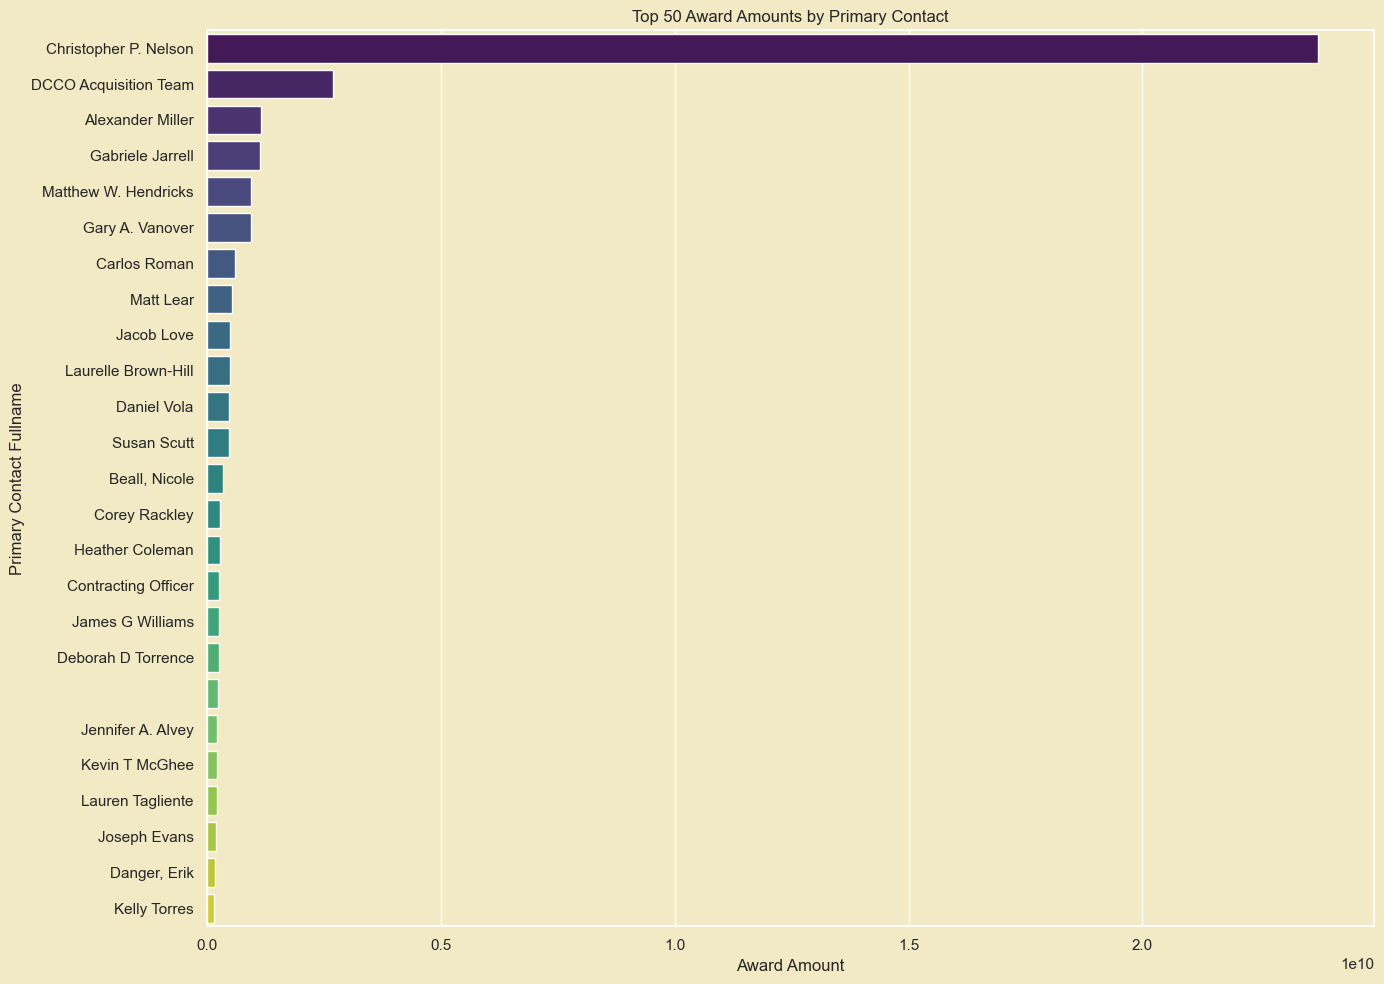

In [668]:
# Convert award_amount back to float for plotting
top_50_df['award_amount'] = top_50_df['award_amount'].str.replace(',', '').astype(float)

# Plot the top 50 award amounts
plt.figure(figsize=(14, 10))
sns.barplot(x='award_amount', y='primarycontactfullname', data=top_50_df, palette='viridis')
plt.title('Top 50 Award Amounts by Primary Contact')
plt.xlabel('Award Amount')
plt.ylabel('Primary Contact Fullname')
plt.tight_layout()
plt.show()

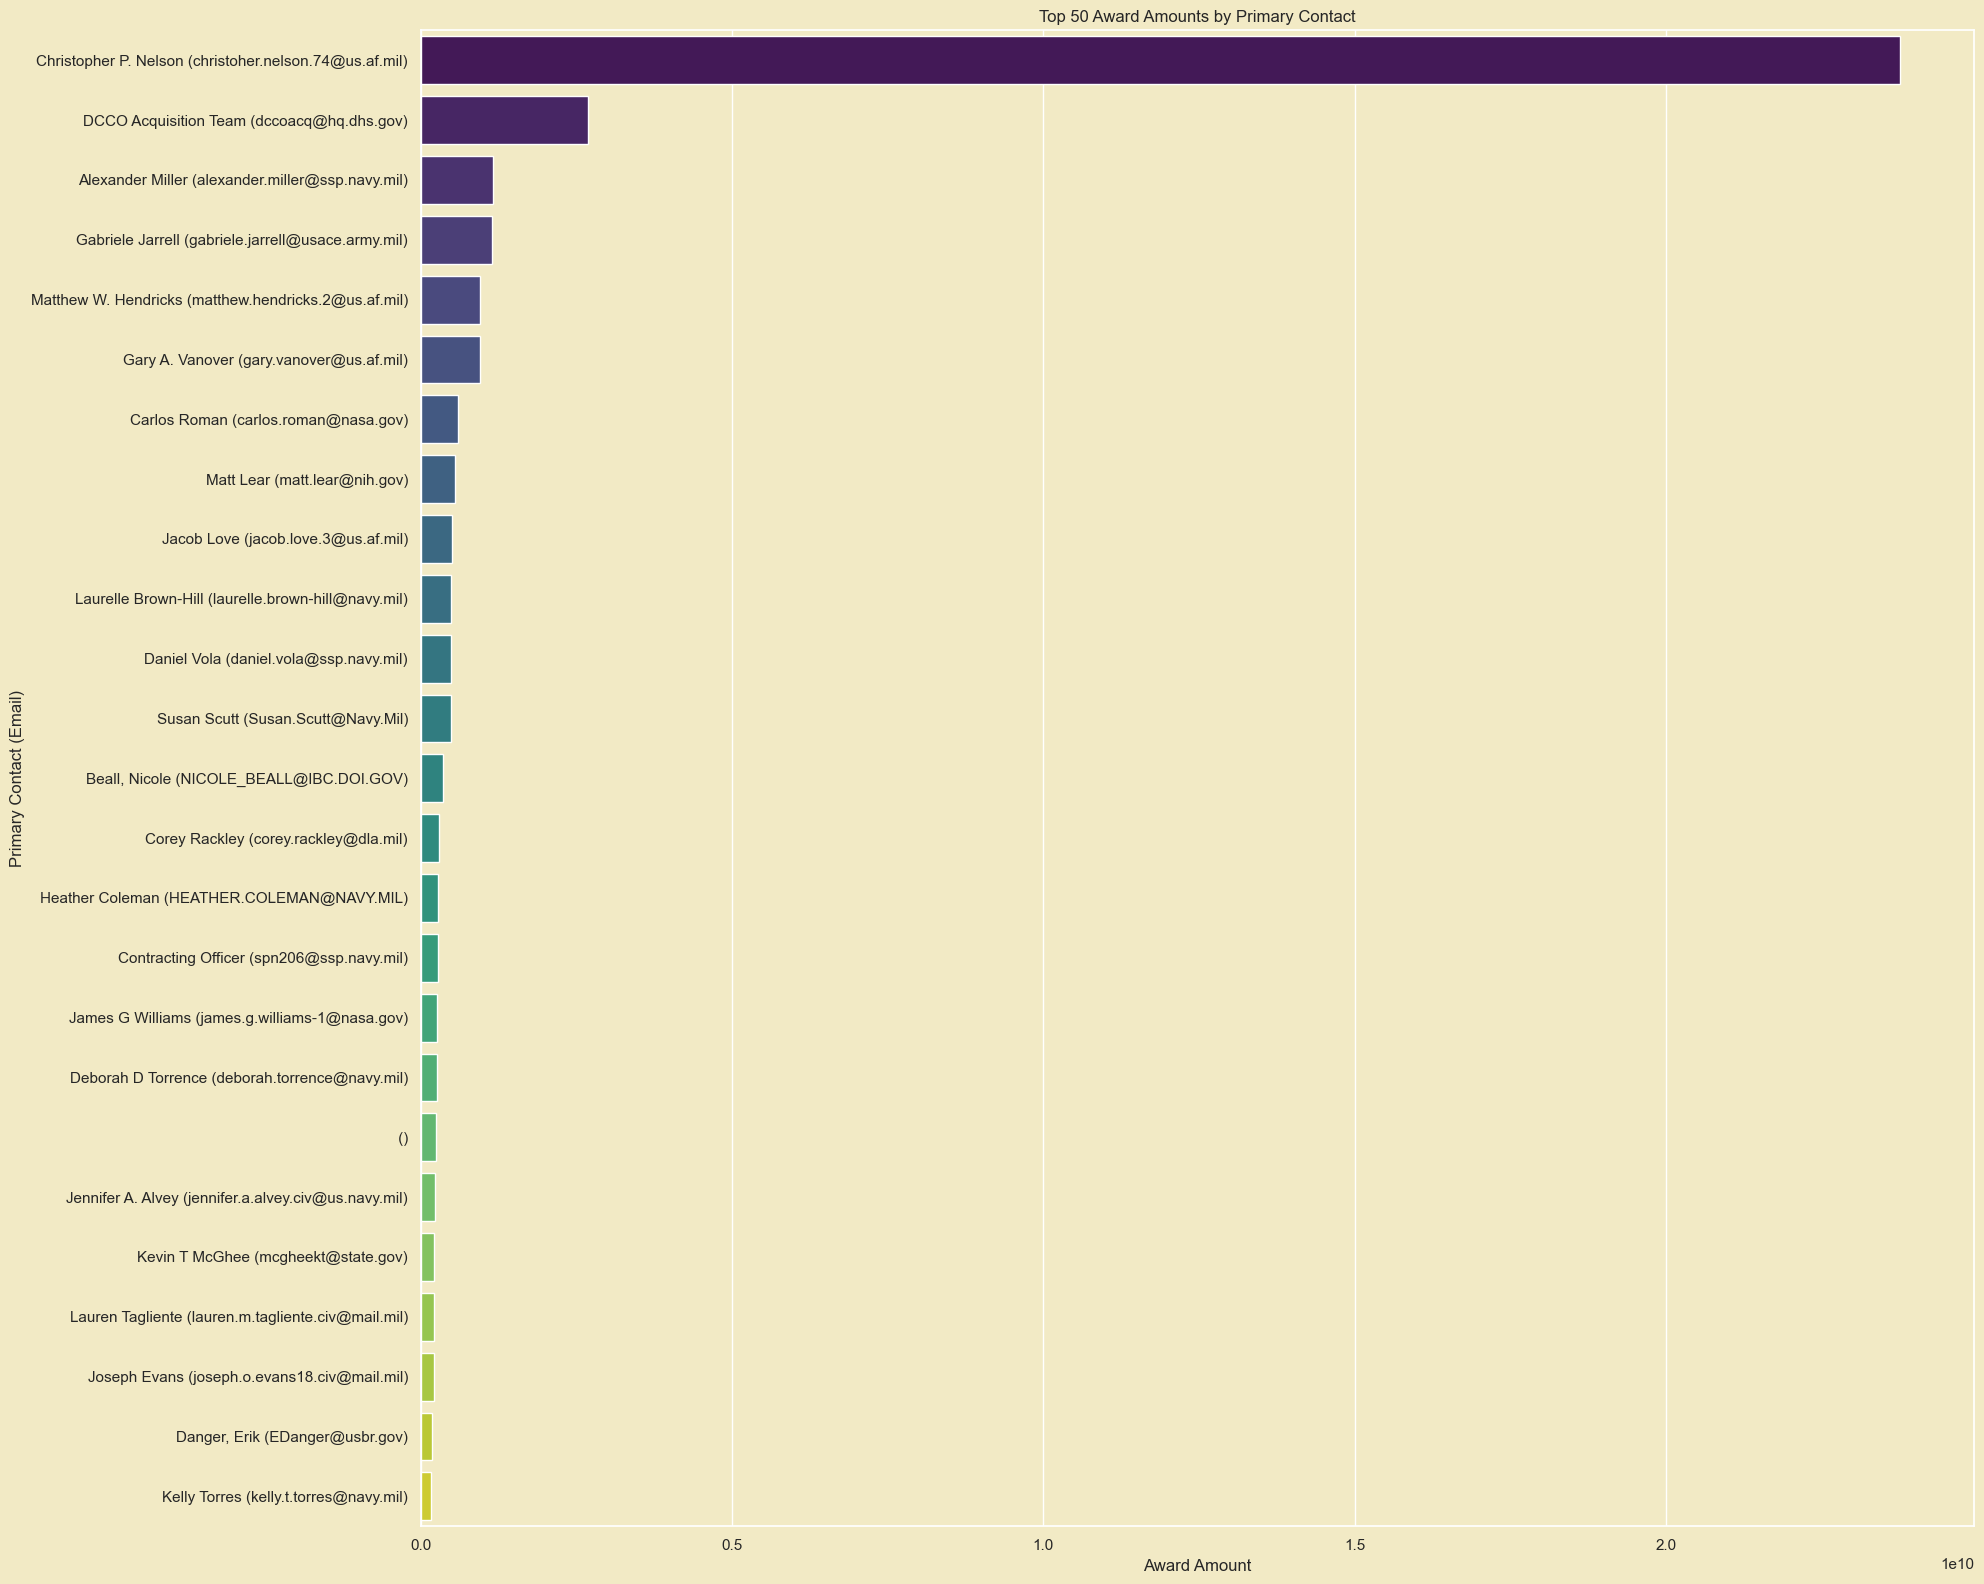

In [669]:
# Concatenate email addresses with primary contact names
top_50_df['contact_info'] = top_50_df['primarycontactfullname'] + ' (' + top_50_df['primarycontactemail'] + ')'

# Convert award_amount back to float for plotting

# Plot the top 50 award amounts
plt.figure(figsize=(20, 16))
sns.barplot(x='award_amount', y='contact_info', data=top_50_df, palette='viridis')
plt.title('Top 50 Award Amounts by Primary Contact')
plt.xlabel('Award Amount')
plt.ylabel('Primary Contact (Email)')
plt.tight_layout()
plt.show()

In [670]:
# Separate numeric and non-numeric columns
numeric_cols = df2022.select(pl.col(pl.Float64) | pl.col(pl.Int64)).columns
non_numeric_cols = df2022.select(pl.col(pl.Utf8)).columns
non_numeric_cols

['noticeid',
 'active',
 'award_',
 'primarycontacttitle',
 'primarycontactfullname',
 'primarycontactemail',
 'primarycontactphone',
 'primarycontactfax',
 'secondarycontacttitle',
 'secondarycontactfullname',
 'secondarycontactemail',
 'secondarycontactphone',
 'secondarycontactfax',
 'organizationtype',
 'additionalinfolink',
 'link']

In [671]:
# Impute missing values for numeric columns
imputer = SimpleImputer(strategy='mean')
imputer

SimpleImputer()

In [672]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(df2022_df):
    # Filter rows based on column: 'award_'
    df2022_df = df2022_df[(df2022_df['award_'].notna()) & (df2022_df['award_'] != "")]
    return df2022_df

# Loaded variable 'df2022' from kernel state
df2022_df = df2022.to_pandas()

df2022_df_clean = clean_data(df2022_df.copy())
df2022_df_clean.head()

,noticeid,title,sol_,department_ind_agency,cgac,sub_tier,fpds_code,office,aac_code,posteddate,...,secondarycontactphone,secondarycontactfax,organizationtype,state,city,zipcode,countrycode,additionalinfolink,link,description
65,89313615041342ffb36bd03ed701d949,708,736,21,47.0,101,58,671,271,14864,...,,,OFFICE,14,25,295,25,,https://sam.gov/opp/89313615041342ffb36bd03ed7...,10912
66,d8a40a817d7d4d508a3ba645db100db4,710,3693,21,47.0,101,58,671,271,14863,...,,,OFFICE,14,25,295,25,,https://sam.gov/opp/d8a40a817d7d4d508a3ba645db...,7727
68,47013088a63e420296fc7f80cc00715f,709,737,21,47.0,101,58,671,271,14861,...,,,OFFICE,14,25,295,25,,https://sam.gov/opp/47013088a63e420296fc7f80cc...,7797
93,7e7334b91eb54e9085f5b0bf8a810e9c,2028,8109,12,97.0,31,124,208,842,14836,...,,,OFFICE,40,90,386,25,,https://sam.gov/opp/7e7334b91eb54e9085f5b0bf8a...,2417
94,e2629067ed364a438f3ba22dffddda18,2026,8111,12,97.0,31,124,208,842,14835,...,,,OFFICE,40,90,386,25,,https://sam.gov/opp/e2629067ed364a438f3ba22dff...,2376


In [673]:
df2022_df_clean.columns

Index(['noticeid', 'title', 'sol_', 'department_ind_agency', 'cgac',
       'sub_tier', 'fpds_code', 'office', 'aac_code', 'posteddate', 'type',
       'basetype', 'archivetype', 'archivedate', 'setasidecode', 'setaside',
       'responsedeadline', 'naicscode', 'classificationcode',
       'popstreetaddress', 'popcity', 'popstate', 'popzip', 'popcountry',
       'active', 'awardnumber', 'awarddate', 'award_', 'awardee',
       'primarycontacttitle', 'primarycontactfullname', 'primarycontactemail',
       'primarycontactphone', 'primarycontactfax', 'secondarycontacttitle',
       'secondarycontactfullname', 'secondarycontactemail',
       'secondarycontactphone', 'secondarycontactfax', 'organizationtype',
       'state', 'city', 'zipcode', 'countrycode', 'additionalinfolink', 'link',
       'description'],
      dtype='object')

In [674]:
# Define features and target
X = df2022_df_clean.drop('award_', axis=1)
y = df2022_df_clean['award_']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [675]:
print(X_train)

                               noticeid  title   sol_  department_ind_agency  \
8996   838f66c169d94f85a2583eea3b70b0bc   2042   8932                     12   
2388   f0b2ce00b4f84bfb8090851c0eb7ad68   1864  10719                     12   
14413  5996210b9c2e4c98a89a3d97529031f6   1417  10728                     12   
1763   3d66716a3fd542e19beb5914ab0d09e0   2164   7423                     12   
14460  867f4e40e857476f85003a1b0e47a60b   9176   1502                     52   
...                                 ...    ...    ...                    ...   
5050   17b4d5ba13224727a874c90d486560a4   7507   1166                     52   
5679   ea6f37431b854e8994e183b2571d3423   2820   1814                     52   
3632   2d11d31a5e9849f8bc2261ba375f2a28   2026   7835                     12   
14680  63347f49d32f44b299dbf15cf62d56bc   3324  10639                     12   
13801  ab9802e1f19f427098f82882527d615e   7450  11277                     12   

       cgac  sub_tier  fpds_code  offic

In [676]:
print(X_test)

                               noticeid  title   sol_  department_ind_agency  \
1382   48dd6ad5974f45f6a54857054621fdc1    645   6445                     12   
1269   ec67509336694a698e6565c27af45fac   2611   8908                     12   
925    ae2d2d499ad94deb843aca765f30a1c9   3225   5767                     12   
5225   72a214ca7b634fd4b50e26d13fdeadff   1844   8911                     12   
9249   86ce01b06d2142a7aa9999b9ef3ec2bb   6053   2996                     12   
...                                 ...    ...    ...                    ...   
121    d459708c61b74a958b7bf8a249db2c71   2081   6759                     12   
5627   c080b20bf1f64ad1a0afae66b19fab8b   2719  10459                     12   
11772  7bde49090ea1462f8fe46a6ea9c2a3ce   2666   8666                     12   
14454  eb17aab5bc9b41c7a015ad3fbad89feb   4061  11552                     12   
2694   a84f49957686486bb797b5ae7a5f7d7c   7425  11720                     12   

       cgac  sub_tier  fpds_code  offic

In [677]:
print(y_train)

8996            250000.00
2388             35403.55
14413            27984.87
1763            250000.00
14460    2320104.00000000
               ...       
5050      123701.50000000
5679       91830.00000000
3632            250000.00
14680            92946.43
13801            62095.00
Name: award_, Length: 2928, dtype: object


In [678]:
print(y_test)

1382        62241.84
1269        57850.00
925        150879.88
5225        42286.00
9249      1163763.90
            ...     
121        250000.00
5627        30031.24
11772       40912.20
14454    14320000.00
2694     49000000.00
Name: award_, Length: 732, dtype: object


In [679]:
# Function to clean currency columns
def clean_currency_columns(df):
    currency_cols = df.columns[df.apply(lambda col: col.astype(str).str.contains(r'\$').any())]
    for col in currency_cols:
        df[col] = df[col].str.replace('[\$,]', '', regex=True).astype(float)
    return df

# Clean X_train and X_test
X_train = clean_currency_columns(X_train)
X_test = clean_currency_columns(X_test)

In [680]:
# Train XGBoost model with enable_categorical=True
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    random_state=42,
    enable_categorical=True
)

In [681]:
X_train.columns

Index(['noticeid', 'title', 'sol_', 'department_ind_agency', 'cgac',
       'sub_tier', 'fpds_code', 'office', 'aac_code', 'posteddate', 'type',
       'basetype', 'archivetype', 'archivedate', 'setasidecode', 'setaside',
       'responsedeadline', 'naicscode', 'classificationcode',
       'popstreetaddress', 'popcity', 'popstate', 'popzip', 'popcountry',
       'active', 'awardnumber', 'awarddate', 'awardee', 'primarycontacttitle',
       'primarycontactfullname', 'primarycontactemail', 'primarycontactphone',
       'primarycontactfax', 'secondarycontacttitle',
       'secondarycontactfullname', 'secondarycontactemail',
       'secondarycontactphone', 'secondarycontactfax', 'organizationtype',
       'state', 'city', 'zipcode', 'countrycode', 'additionalinfolink', 'link',
       'description'],
      dtype='object')

In [682]:
# Extract the first letter of each column name
first_letters = pd.Series(X_train.columns).str[0].str.lower()

# Count the number of variables by the first letter
first_letter_counts = first_letters.value_counts().reset_index()
first_letter_counts.columns = ['first_letter', 'count']

# Display the counts
print(first_letter_counts)

   first_letter  count
0             p     11
1             s     10
2             a      8
3             c      4
4             n      2
5             t      2
6             d      2
7             o      2
8             f      1
9             b      1
10            r      1
11            z      1
12            l      1


In [683]:
# Find columns starting with 'aw'
a_columns = [col for col in X_train.columns ]
print("Columns starting with 'a':", a_columns)

# Display the first few rows of X_train
print(X_train[a_columns])

Columns starting with 'a': ['noticeid', 'title', 'sol_', 'department_ind_agency', 'cgac', 'sub_tier', 'fpds_code', 'office', 'aac_code', 'posteddate', 'type', 'basetype', 'archivetype', 'archivedate', 'setasidecode', 'setaside', 'responsedeadline', 'naicscode', 'classificationcode', 'popstreetaddress', 'popcity', 'popstate', 'popzip', 'popcountry', 'active', 'awardnumber', 'awarddate', 'awardee', 'primarycontacttitle', 'primarycontactfullname', 'primarycontactemail', 'primarycontactphone', 'primarycontactfax', 'secondarycontacttitle', 'secondarycontactfullname', 'secondarycontactemail', 'secondarycontactphone', 'secondarycontactfax', 'organizationtype', 'state', 'city', 'zipcode', 'countrycode', 'additionalinfolink', 'link', 'description']
                               noticeid  title   sol_  department_ind_agency  \
8996   838f66c169d94f85a2583eea3b70b0bc   2042   8932                     12   
2388   f0b2ce00b4f84bfb8090851c0eb7ad68   1864  10719                     12   
14413  599

In [684]:
X_train=X_train[a_columns]
X_test=X_test[a_columns]

In [685]:
# Remove the specified columns
X_train = X_train.drop(columns=['noticeid', 'additionalinfolink', 'link'])
X_test = X_test.drop(columns=['noticeid', 'additionalinfolink', 'link'])

# Display the updated dataframes
print(X_train.head())
print(X_test.head())

       title   sol_  department_ind_agency  cgac  sub_tier  fpds_code  office  \
8996    2042   8932                     12  97.0        31        124     208   
2388    1864  10719                     12  97.0        31        124     216   
14413   1417  10728                     12  97.0        31        124     216   
1763    2164   7423                     12  97.0        31        124     208   
14460   9176   1502                     52  36.0       129         55      20   

       aac_code  posteddate  type  ...  secondarycontactfullname  \
8996        853        5979     0  ...                             
2388        865       12554     0  ...                             
14413       865         581     0  ...                             
1763        842       13176     0  ...                             
14460       236         534     0  ...                             

       secondarycontactemail  secondarycontactphone  secondarycontactfax  \
8996                        

In [686]:
# Remove '$' and ',' then convert to float
#y_train = y_train.str.replace(r'[\$,]', '', regex=True).astype(float)
y_test = y_test.str.replace(r'[\$,]', '', regex=True).astype(float)

In [687]:
# Check the number of columns
print("Number of columns in X_train:", X_train.shape[1])
print("Number of columns in X_test:", X_test.shape[1])

Number of columns in X_train: 43
Number of columns in X_test: 43


In [688]:
# Identify object columns
object_columns = X_train.select_dtypes(include=['object']).columns

# Clean columns containing '$'
for col in object_columns:
    if X_train[col].astype(str).str.contains('\$').any():
        X_train[col] = X_train[col].str.replace(r'[\$,]', '', regex=True).astype(float)
        X_test[col] = X_test[col].str.replace(r'[\$,]', '', regex=True).astype(float)

# Drop non-numeric columns without '$'
X_train = X_train.select_dtypes(include=[np.number])
X_test = X_test[X_train.columns]

# Ensure X_train and X_test have the same columns
X_test = X_test[X_train.columns]


In [689]:
# Fit the XGBoost model
xgb_model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    verbose=True
)

[0]	validation_0-rmse:143489099.63897
[1]	validation_0-rmse:235509273.82635
[2]	validation_0-rmse:325184300.55169
[3]	validation_0-rmse:404056783.17646
[4]	validation_0-rmse:471942740.39806
[5]	validation_0-rmse:529929204.54631
[6]	validation_0-rmse:532145833.35058
[7]	validation_0-rmse:537670839.86990
[8]	validation_0-rmse:544913674.23930
[9]	validation_0-rmse:552731609.57905
[10]	validation_0-rmse:560917370.23027
[11]	validation_0-rmse:568704476.70099
[12]	validation_0-rmse:575798483.43753
[13]	validation_0-rmse:582235309.92432
[14]	validation_0-rmse:588035292.16433
[15]	validation_0-rmse:593111377.86518
[16]	validation_0-rmse:597437930.74182
[17]	validation_0-rmse:601314478.23055
[18]	validation_0-rmse:604631588.65634
[19]	validation_0-rmse:607547520.83713
[20]	validation_0-rmse:610112406.50412
[21]	validation_0-rmse:612264531.43834
[22]	validation_0-rmse:614124047.10581
[23]	validation_0-rmse:615668411.54562
[24]	validation_0-rmse:617028607.72902
[25]	validation_0-rmse:618154895.16

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [690]:
xgb_predictions = xgb_model.predict(X_test)

# Evaluate the model
xgb_mse = mean_squared_error(y_test, xgb_predictions)
xgb_r2 = r2_score(y_test, xgb_predictions)

XGBoost MSE: 3.8256772251782656e+17, R2: -26.867642163956717


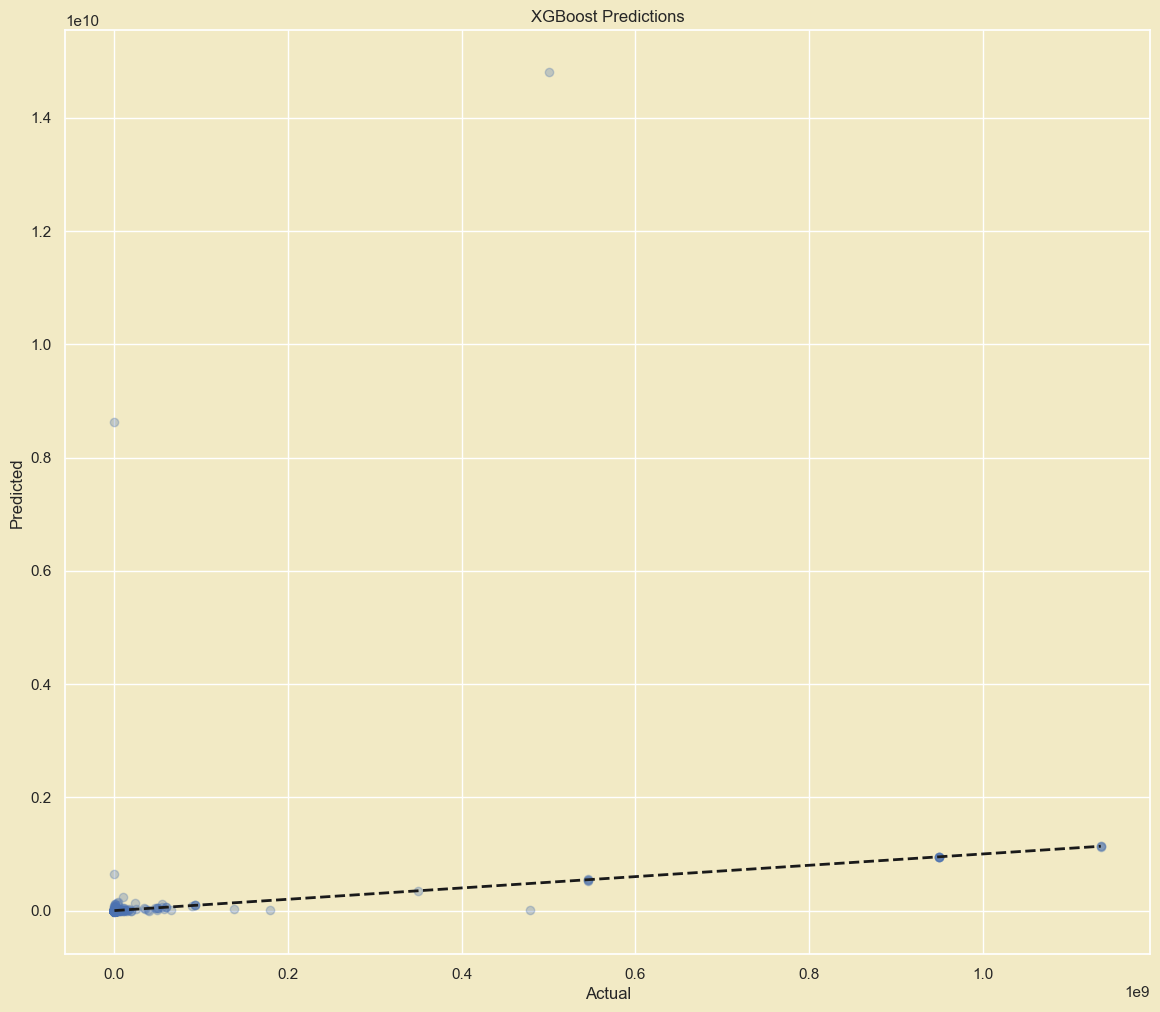

In [691]:
print(f"XGBoost MSE: {xgb_mse}, R2: {xgb_r2}")

# Plot the results
plt.figure(figsize=(14, 12))
plt.scatter(y_test, xgb_predictions, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('XGBoost Predictions')
plt.show()

In [692]:
def clean_column_names(df):
    # Replace spaces and slashes with underscores
    df.columns = [col.replace(' ', '_').replace('/', '_') for col in df.columns]
    # Convert to lowercase
    df.columns = [col.lower() for col in df.columns]
    return df

# Assuming df2023 is your DataFrame
df2023 = clean_column_names(df)

In [693]:
# Define prediction function to match provided columns
def predict_popularity(title, department_agency, cgac, sub_tier, fpds_code, office, aac_code, 
                       posted_date, contract_type, base_type, archive_type, darchive_date, 
                       set_aside_code, set_aside, response_deadline, naics_code, 
                       classification_code, pop_street_address, pop_city, pop_state,
                       pop_zip, pop_country, award_number, award_date, award_amount,
                       awardee, primary_contact_title, primary_contact_fullname,
                       primary_contact_email, primary_contact_phone, primary_contact_fax, 
                       secondary_contact_title, secondary_contact_fullname, secondary_contact_email, 
                       secondary_contact_phone, secondary_contact_fax, organization_type, state, 
                       city, zip_code, country_code, additional_info_link, link, description):

    # Hash specific text fields to match the model's expected input format
    title_hashed = hash(str(title)) % 10**8
    department_agency_hashed = hash(str(department_agency)) % 10**8
    sub_tier_hashed = hash(str(sub_tier)) % 10**8
    awardee_hashed = hash(str(awardee)) % 10**8

    # Create a DataFrame for the input, matching the column names in X
    input_data = pd.DataFrame([[
        title_hashed, department_agency_hashed, cgac, sub_tier_hashed, fpds_code,
        office, aac_code, posted_date, contract_type, base_type, archive_type,
        set_aside_code, set_aside, response_deadline, naics_code, classification_code,
        pop_street_address, pop_city, pop_state, pop_zip, pop_country,
        award_number, award_date, award_amount, awardee_hashed, primary_contact_title,
        primary_contact_fullname, primary_contact_email, primary_contact_phone,
        primary_contact_fax, secondary_contact_title, secondary_contact_fullname,
        secondary_contact_email, secondary_contact_phone, secondary_contact_fax,
        organization_type, state, city, zip_code, country_code, additional_info_link,
        link, description
    ]], columns=X.columns)

    # Define numeric columns, if any, to normalize
    # (Assume 'award_amount' as a numerical example, modify as needed based on your data)
    numerical_cols = ['award_amount']
    input_data[numerical_cols] = (input_data[numerical_cols] - X[numerical_cols].mean()) / X[numerical_cols].std()

    # Return the DataFrame ready for prediction
    return input_data


In [694]:
X_train.dtypes.to_frame('Data Type')

,Data Type
title,int64
sol_,int64
department_ind_agency,int64
cgac,float64
sub_tier,int64
fpds_code,int64
office,int64
aac_code,int64
posteddate,int64
type,int64


In [695]:
# Missing values in each row
missing_values_per_row = X_train.isnull().sum(axis=1)
count_per_missing_value = missing_values_per_row.value_counts().sort_index()

# Print the results
for missing, rows in count_per_missing_value.items():
    print(f'{rows} row(s) have {missing} missing values')

total_rows_with_missing_values = (X_train.isnull().any(axis=1)).sum()
print(f'Total number of rows with missing values: {total_rows_with_missing_values}')

2928 row(s) have 0 missing values
Total number of rows with missing values: 0


In [696]:
dist_numerical_cols = X_train.describe().T[['min', 'max']]
dist_numerical_cols['Missing Values'] = X_train.isnull().sum()
dist_numerical_cols['Missing Percentage'] = (X_train.isnull().mean() * 100).round(2)

The output shows that all numeric columns have a missing value percentage of 0, indicating that **there are no missing values** in these columns.

To gain further insights into the data, we used the `describe()` method to generate a comprehensive statistical summary of the numerical columns.

**👉 Distribution of numerical columns**

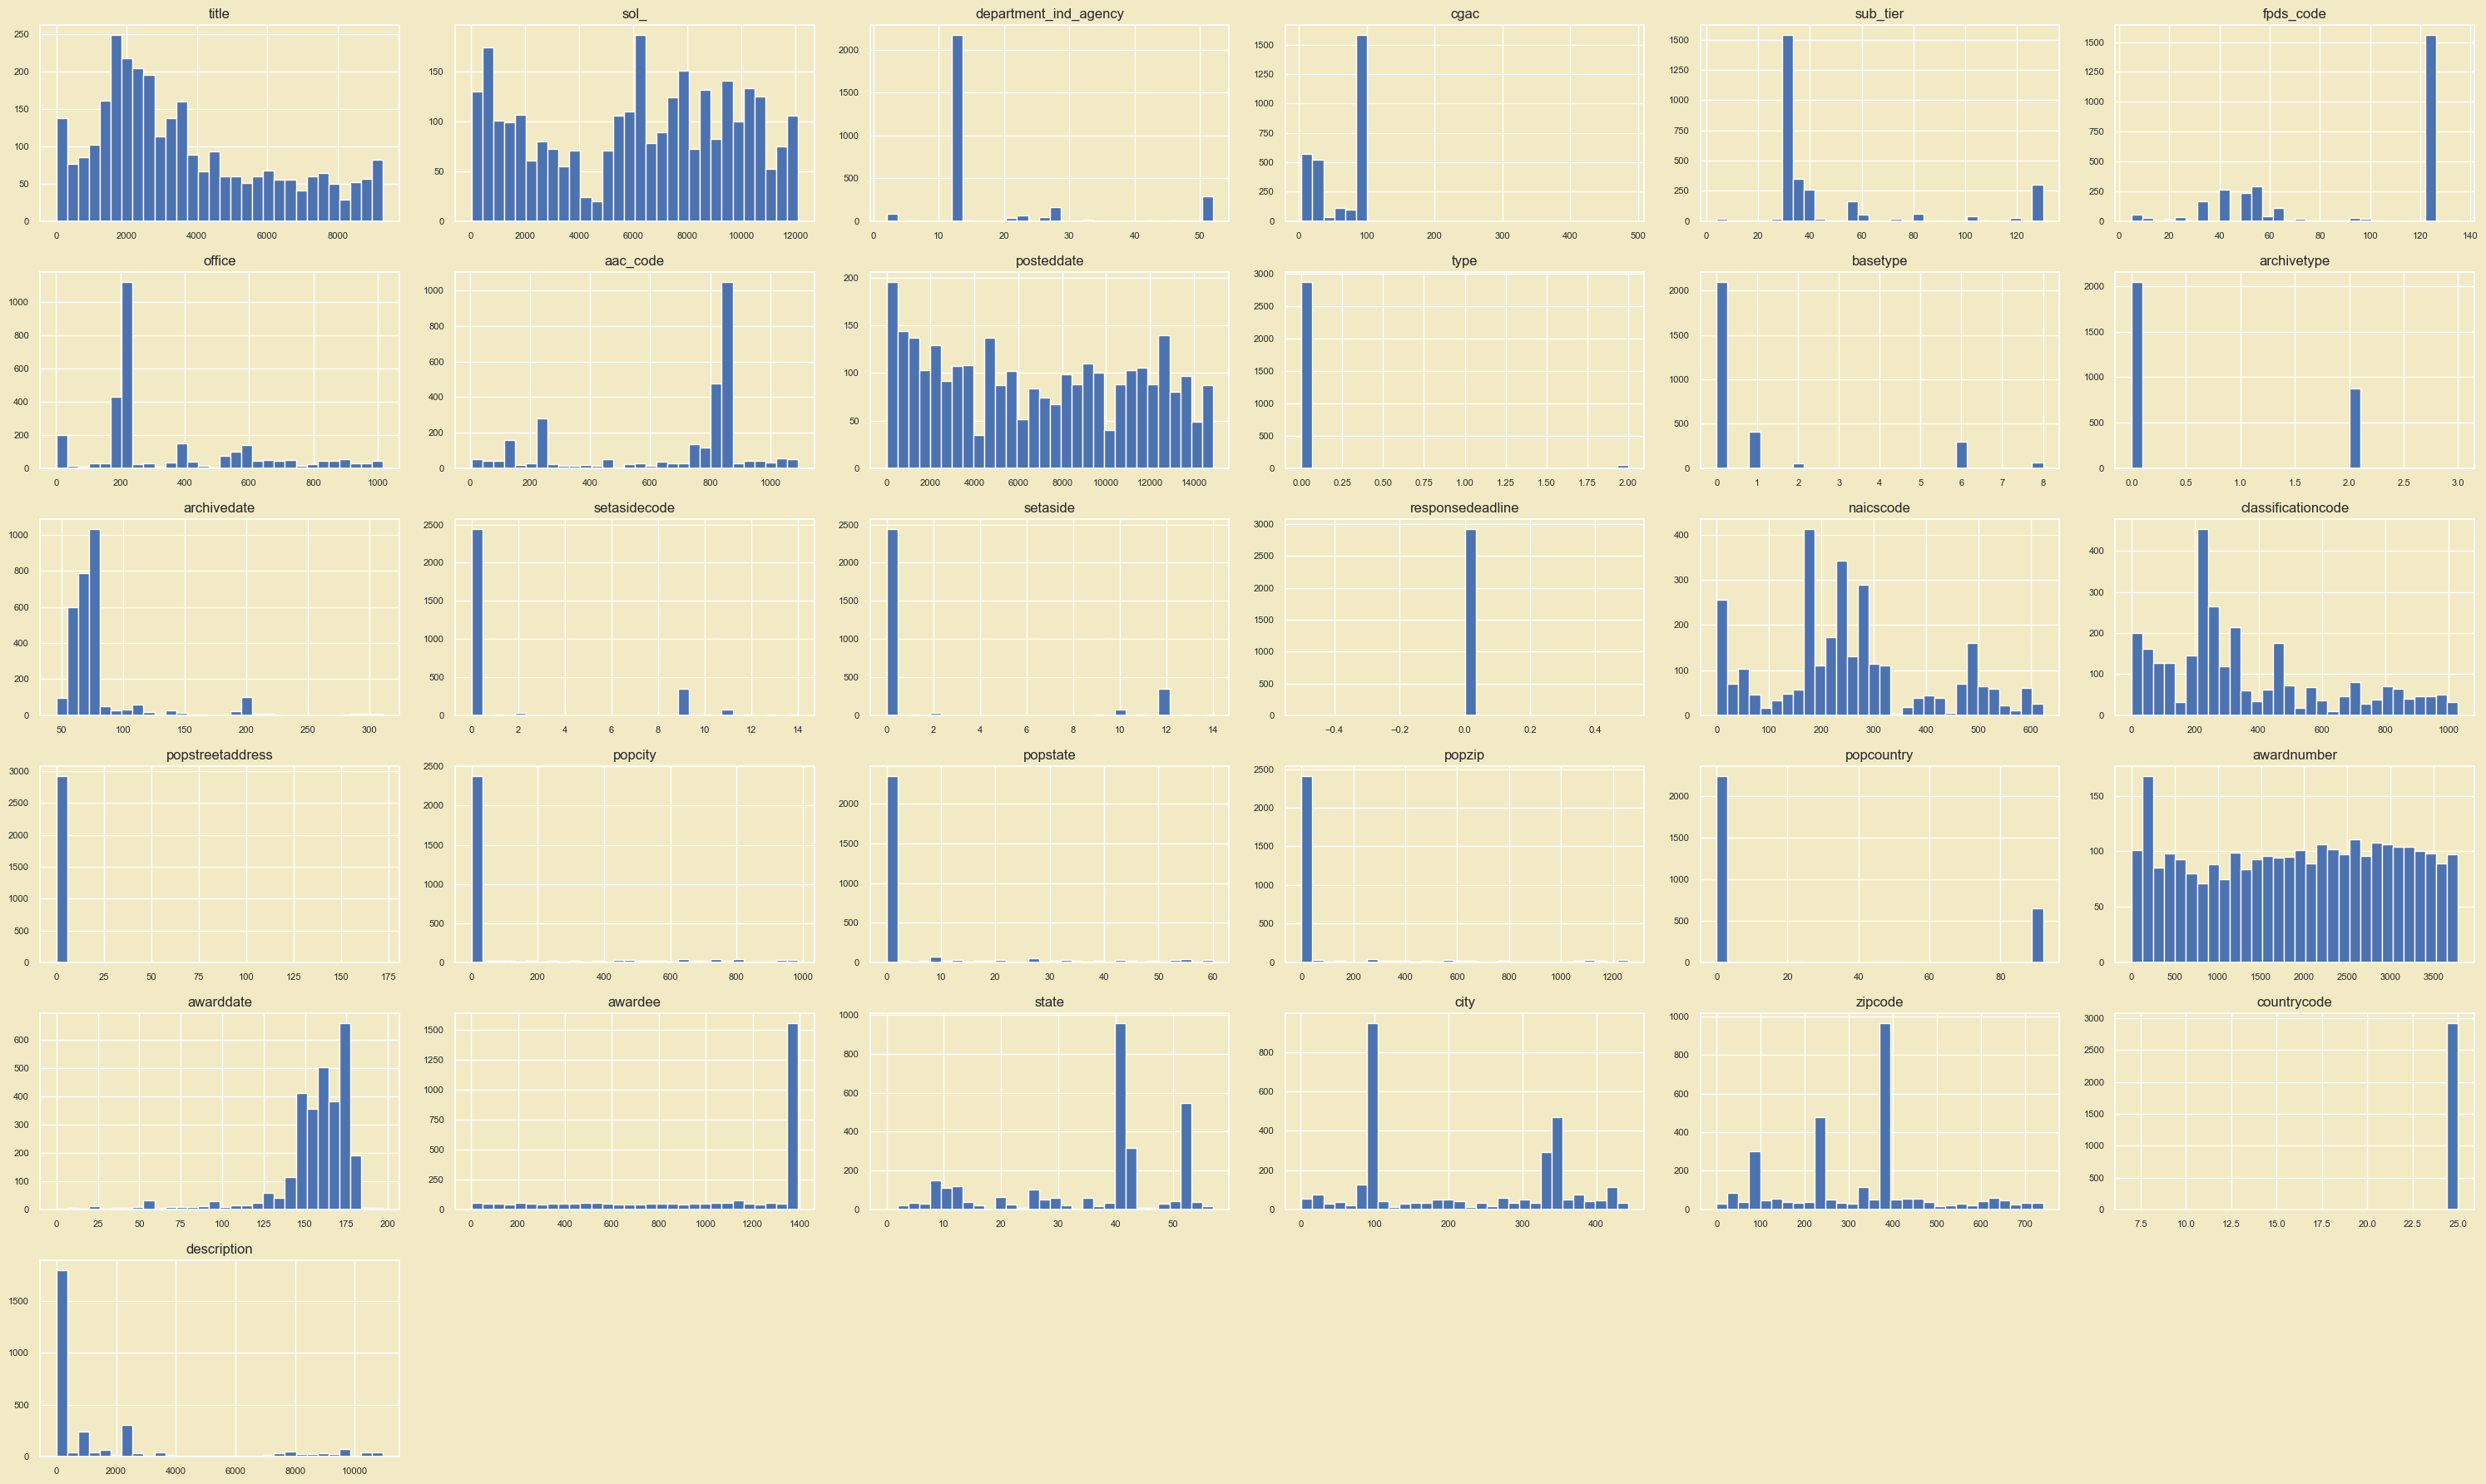

In [697]:
sns.set_style('darkgrid')
sns.set(rc={"axes.facecolor":"#F2EAC5","figure.facecolor":"#F2EAC5"})
X_train.hist(figsize=(30,18), bins=30, xlabelsize=8, ylabelsize=8)
plt.tight_layout()
plt.show()

<Figure size 3200x1500 with 0 Axes>

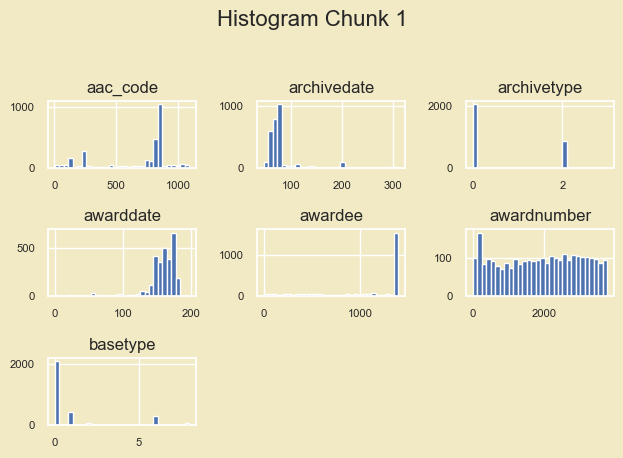

<Figure size 3200x1500 with 0 Axes>

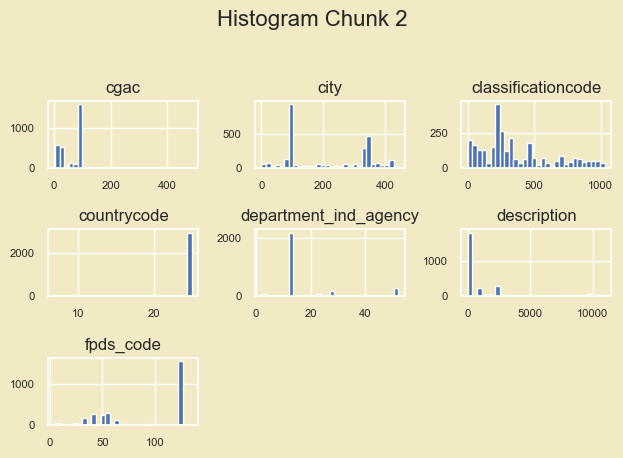

<Figure size 3200x1500 with 0 Axes>

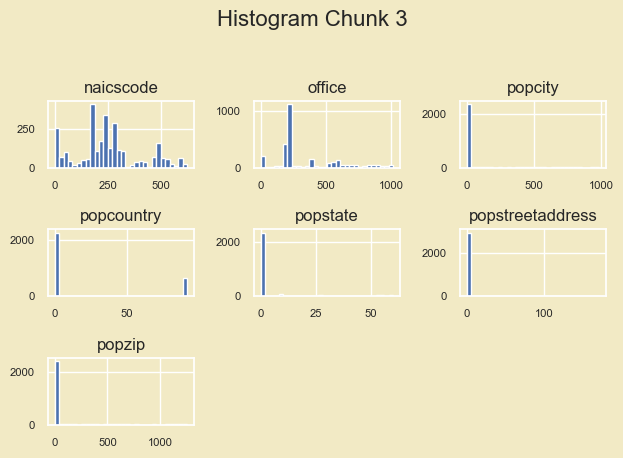

<Figure size 3200x1500 with 0 Axes>

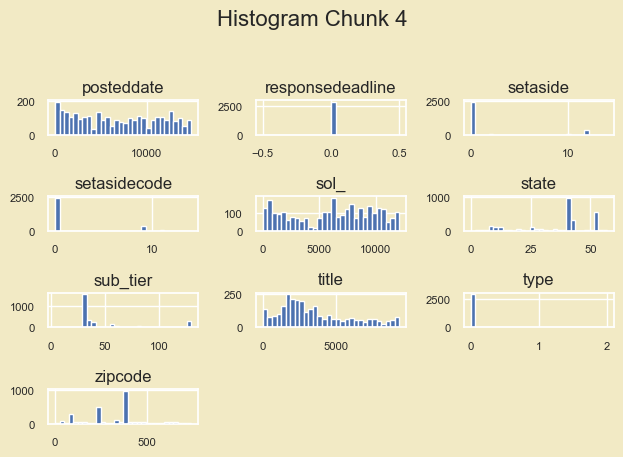

In [698]:
# Set Seaborn style
sns.set_style('darkgrid')
sns.set(rc={"axes.facecolor": "#F2EAC5", "figure.facecolor": "#F2EAC5"})

# Sort the columns by name
sorted_columns = sorted(X_train.columns)

# Split columns into four roughly equal parts
num_chunks = 4
chunk_size = len(sorted_columns) // num_chunks
chunks = [sorted_columns[i * chunk_size:(i + 1) * chunk_size] for i in range(num_chunks)]

# If there are remaining columns, add them to the last chunk
if len(sorted_columns) % num_chunks != 0:
    chunks[-1].extend(sorted_columns[num_chunks * chunk_size:])

# Plot histograms for each chunk
for idx, chunk in enumerate(chunks, 1):
    plt.figure(figsize=(32, 15))
    X_train[chunk].hist(bins=30, xlabelsize=8, ylabelsize=8)
    plt.suptitle(f'Histogram Chunk {idx}', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [699]:
unique_values = X_train.nunique()
missing_values = X_train.isnull().sum()

summary = pd.DataFrame({
    'Unique Values': unique_values,
    'Missing Values': missing_values
})

In [700]:
summary_sorted = summary.sort_values(by='Unique Values', ascending=True)

print(summary_sorted)

                       Unique Values  Missing Values
responsedeadline                   1               0
popstreetaddress                   2               0
countrycode                        2               0
type                               2               0
archivetype                        3               0
basetype                           6               0
setasidecode                      11               0
setaside                          11               0
popcountry                        17               0
department_ind_agency             24               0
cgac                              26               0
popstate                          51               0
state                             54               0
sub_tier                          66               0
fpds_code                         66               0
archivedate                      120               0
awarddate                        155               0
city                             234          

In [701]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2928 entries, 8996 to 13801
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   title                  2928 non-null   int64  
 1   sol_                   2928 non-null   int64  
 2   department_ind_agency  2928 non-null   int64  
 3   cgac                   2928 non-null   float64
 4   sub_tier               2928 non-null   int64  
 5   fpds_code              2928 non-null   int64  
 6   office                 2928 non-null   int64  
 7   aac_code               2928 non-null   int64  
 8   posteddate             2928 non-null   int64  
 9   type                   2928 non-null   int64  
 10  basetype               2928 non-null   int64  
 11  archivetype            2928 non-null   int64  
 12  archivedate            2928 non-null   int64  
 13  setasidecode           2928 non-null   int64  
 14  setaside               2928 non-null   int64  
 15  respo

In [702]:
# Import necessary libraries
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

In [703]:
# Fit Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

# Fit Ridge Regression model
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)
ridge_predictions = ridge_model.predict(X_test)

# Evaluate the models
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_r2 = r2_score(y_test, rf_predictions)

ridge_mse = mean_squared_error(y_test, ridge_predictions)
ridge_r2 = r2_score(y_test, ridge_predictions)

print(f"Random Forest MSE: {rf_mse}, R2: {rf_r2}")
print(f"Ridge Regression MSE: {ridge_mse}, R2: {ridge_r2}")

Random Forest MSE: 4.025229387125815e+16, R2: -1.932125362014514
Ridge Regression MSE: 1.116982699764682e+16, R2: 0.18634865546133472


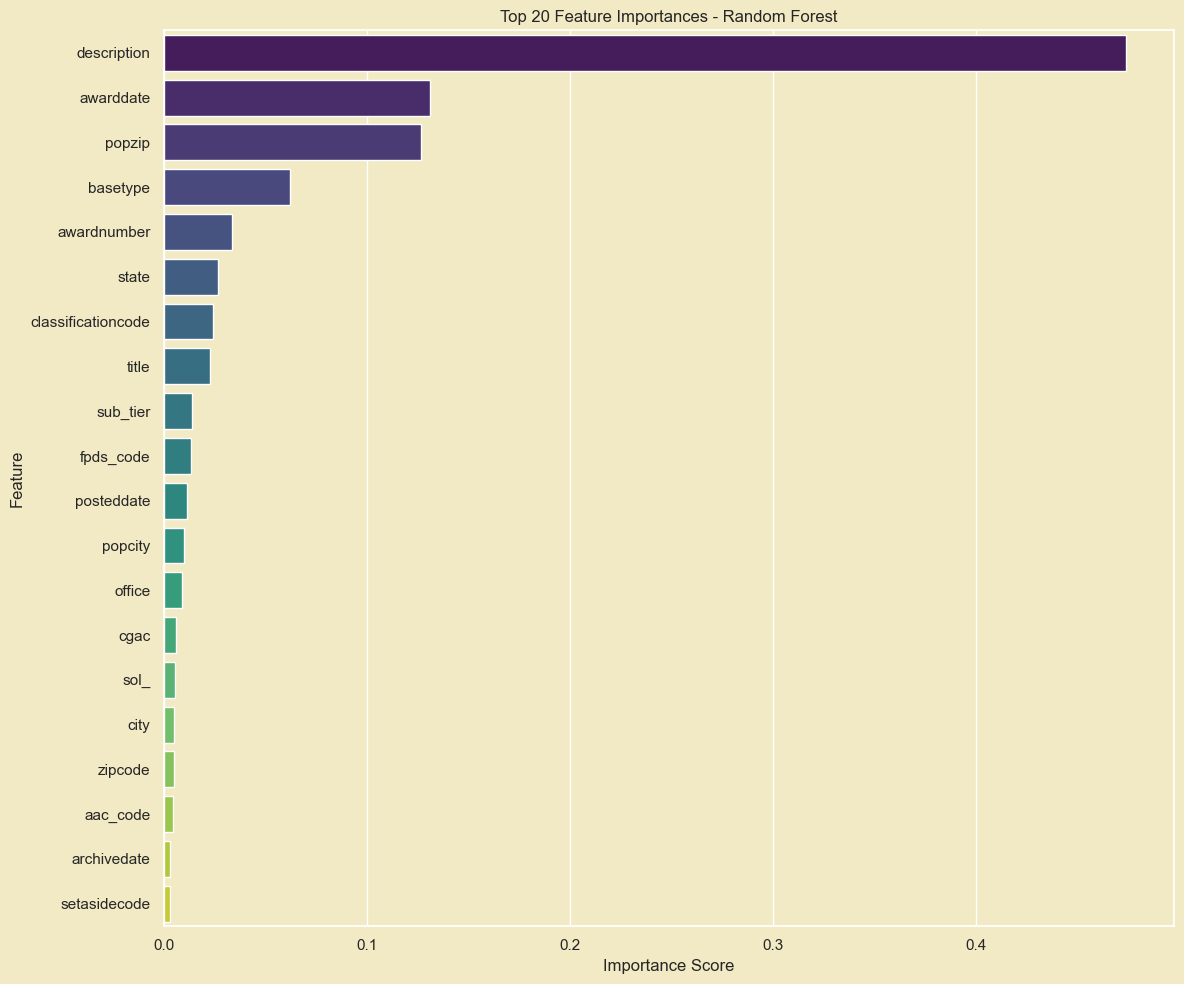

In [704]:
# Set Seaborn style
sns.set_style('darkgrid')
sns.set(rc={"axes.facecolor": "#F2EAC5", "figure.facecolor": "#F2EAC5"})

# 1. Feature Importance for Random Forest
importances = rf_model.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False).head(20)  # Top 20 features

plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis')
plt.title('Top 20 Feature Importances - Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

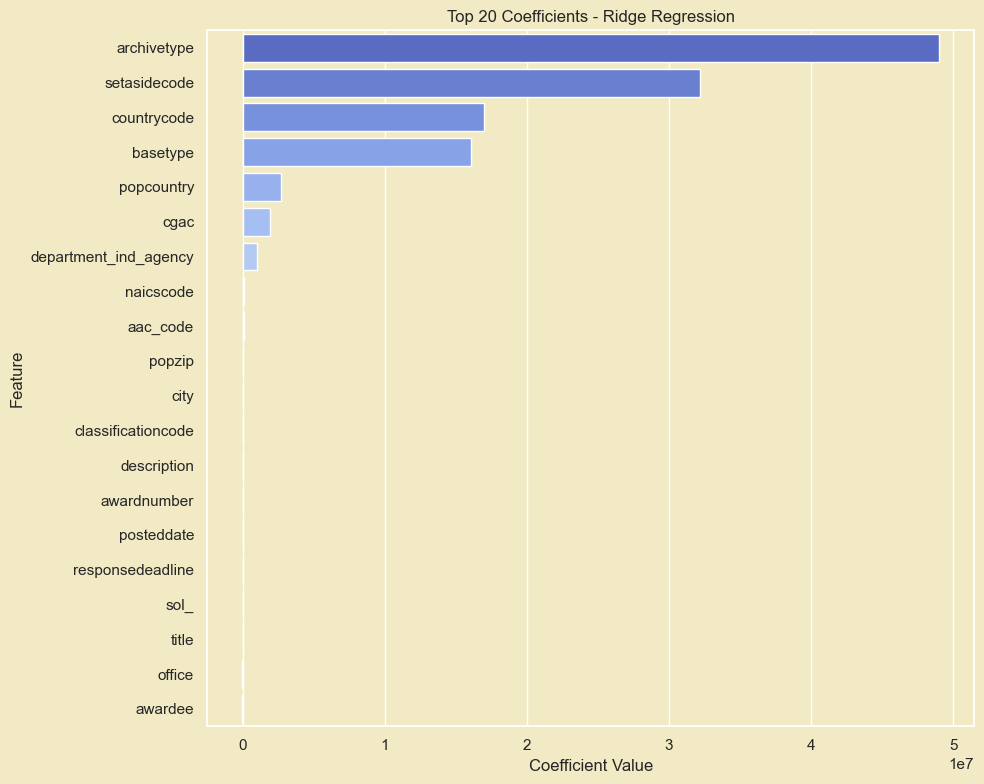

In [705]:
# 2. Coefficient Analysis for Ridge Regression
coefficients = ridge_model.coef_
coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients
}).sort_values(by='coefficient', ascending=False).head(20)  # Top 20 positive coefficients

plt.figure(figsize=(10, 8))
sns.barplot(x='coefficient', y='feature', data=coef_df, palette='coolwarm')
plt.title('Top 20 Coefficients - Ridge Regression')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

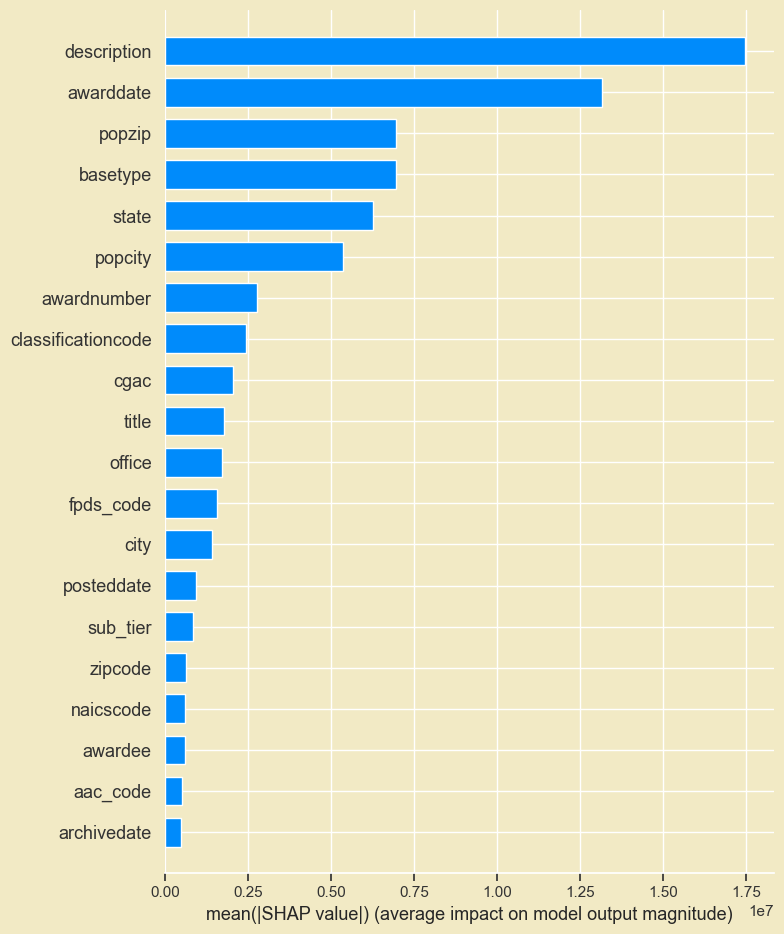

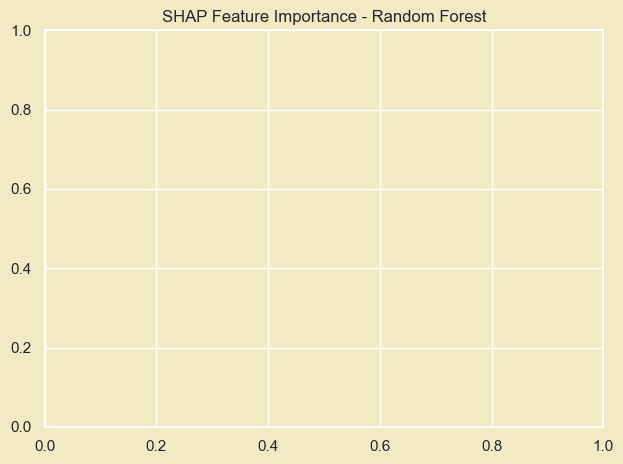

In [706]:
# 3. SHAP Values for Model Explainability
# Random Forest SHAP
explainer_rf = shap.TreeExplainer(rf_model)
shap_values_rf = explainer_rf.shap_values(X_test)

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_rf, X_test, plot_type="bar")
plt.title('SHAP Feature Importance - Random Forest')
plt.tight_layout()
plt.show()

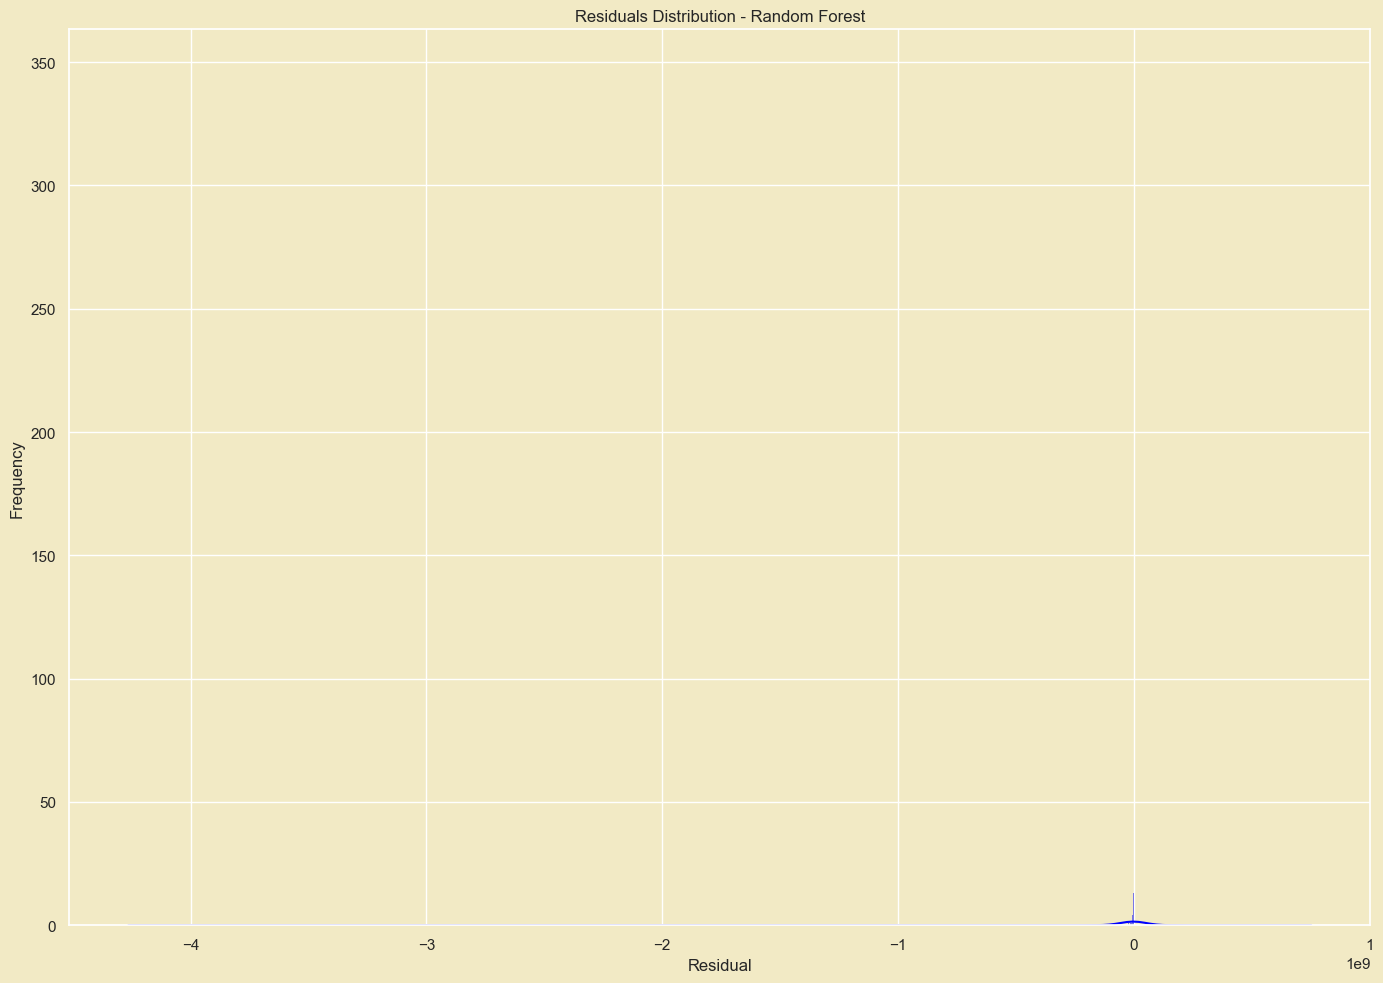

In [707]:
# 4. Residual Plots
# Random Forest Residuals
rf_residuals = y_test - rf_predictions
plt.figure(figsize=(14, 10))
sns.histplot(rf_residuals, kde=True, color='blue')
plt.title('Residuals Distribution - Random Forest')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

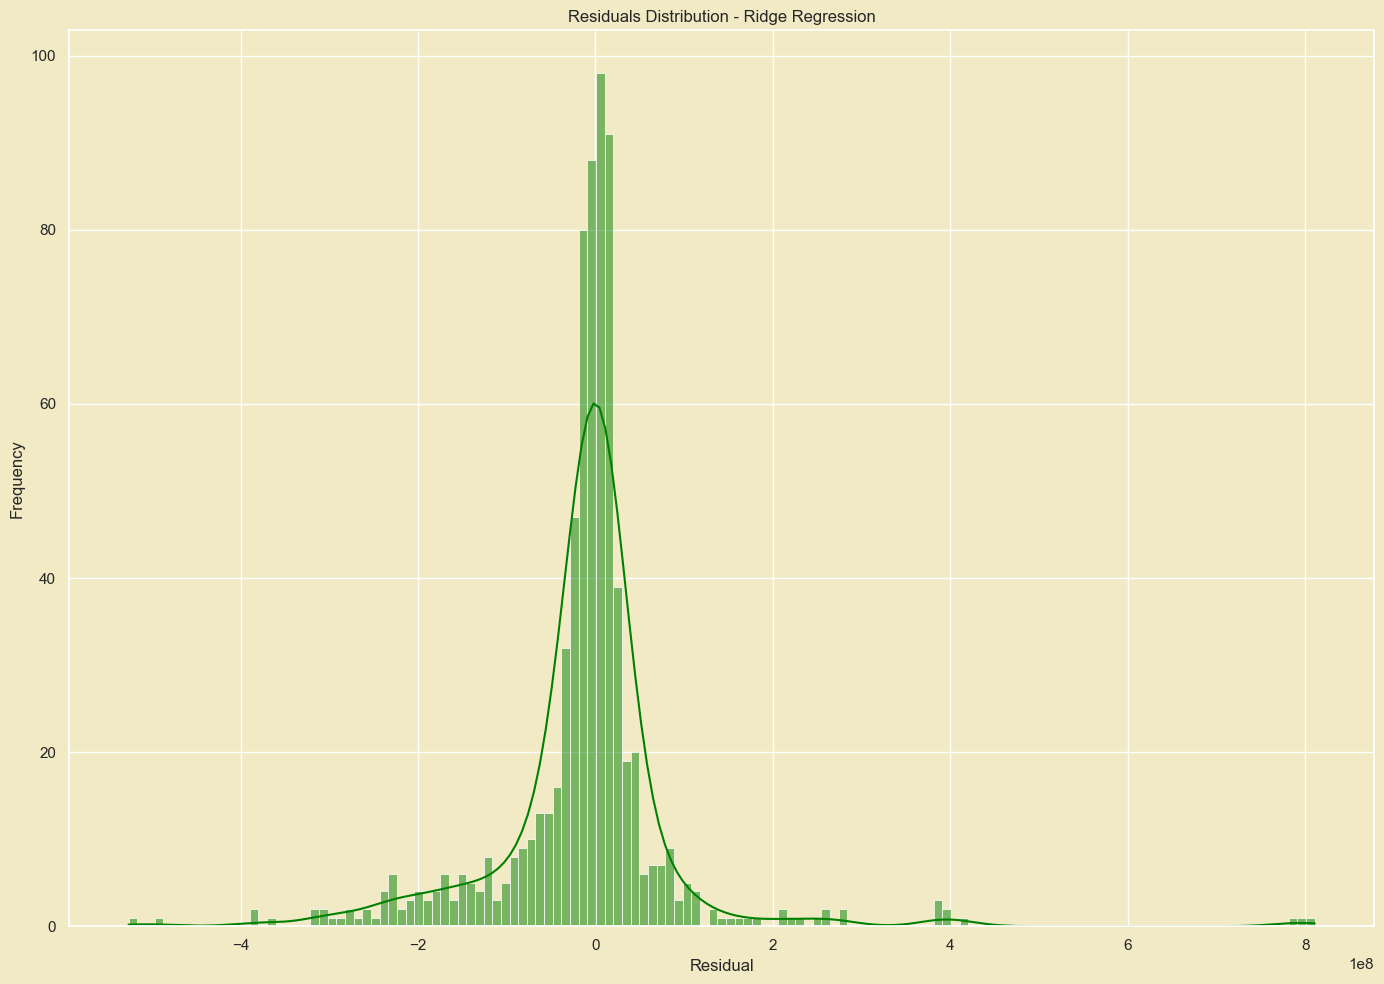

In [708]:
# Ridge Regression Residuals
ridge_residuals = y_test - ridge_predictions
plt.figure(figsize=(14, 10))
sns.histplot(ridge_residuals, kde=True, color='green')
plt.title('Residuals Distribution - Ridge Regression')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Actual vs. Predicted - Random Forest')

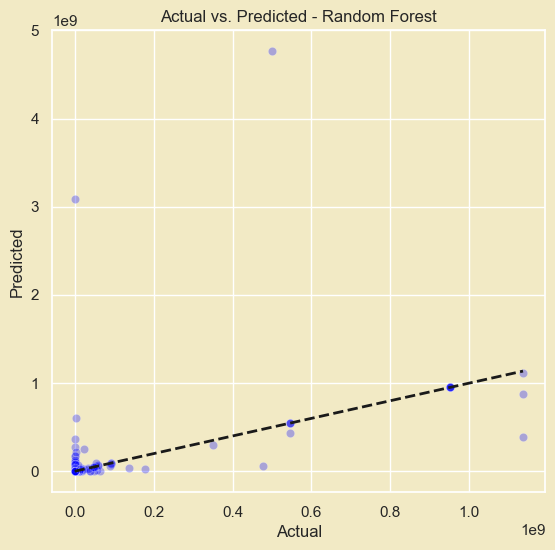

In [709]:
# 5. Actual vs. Predicted Scatter Plots
plt.figure(figsize=(14, 6))

# Random Forest
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test, y=rf_predictions, alpha=0.3, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted - Random Forest')

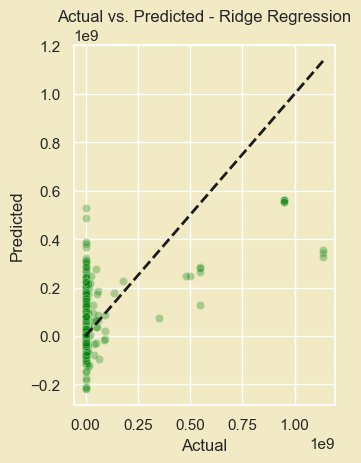

In [710]:
# Ridge Regression
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y=ridge_predictions, alpha=0.3, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted - Ridge Regression')

plt.tight_layout()
plt.show()

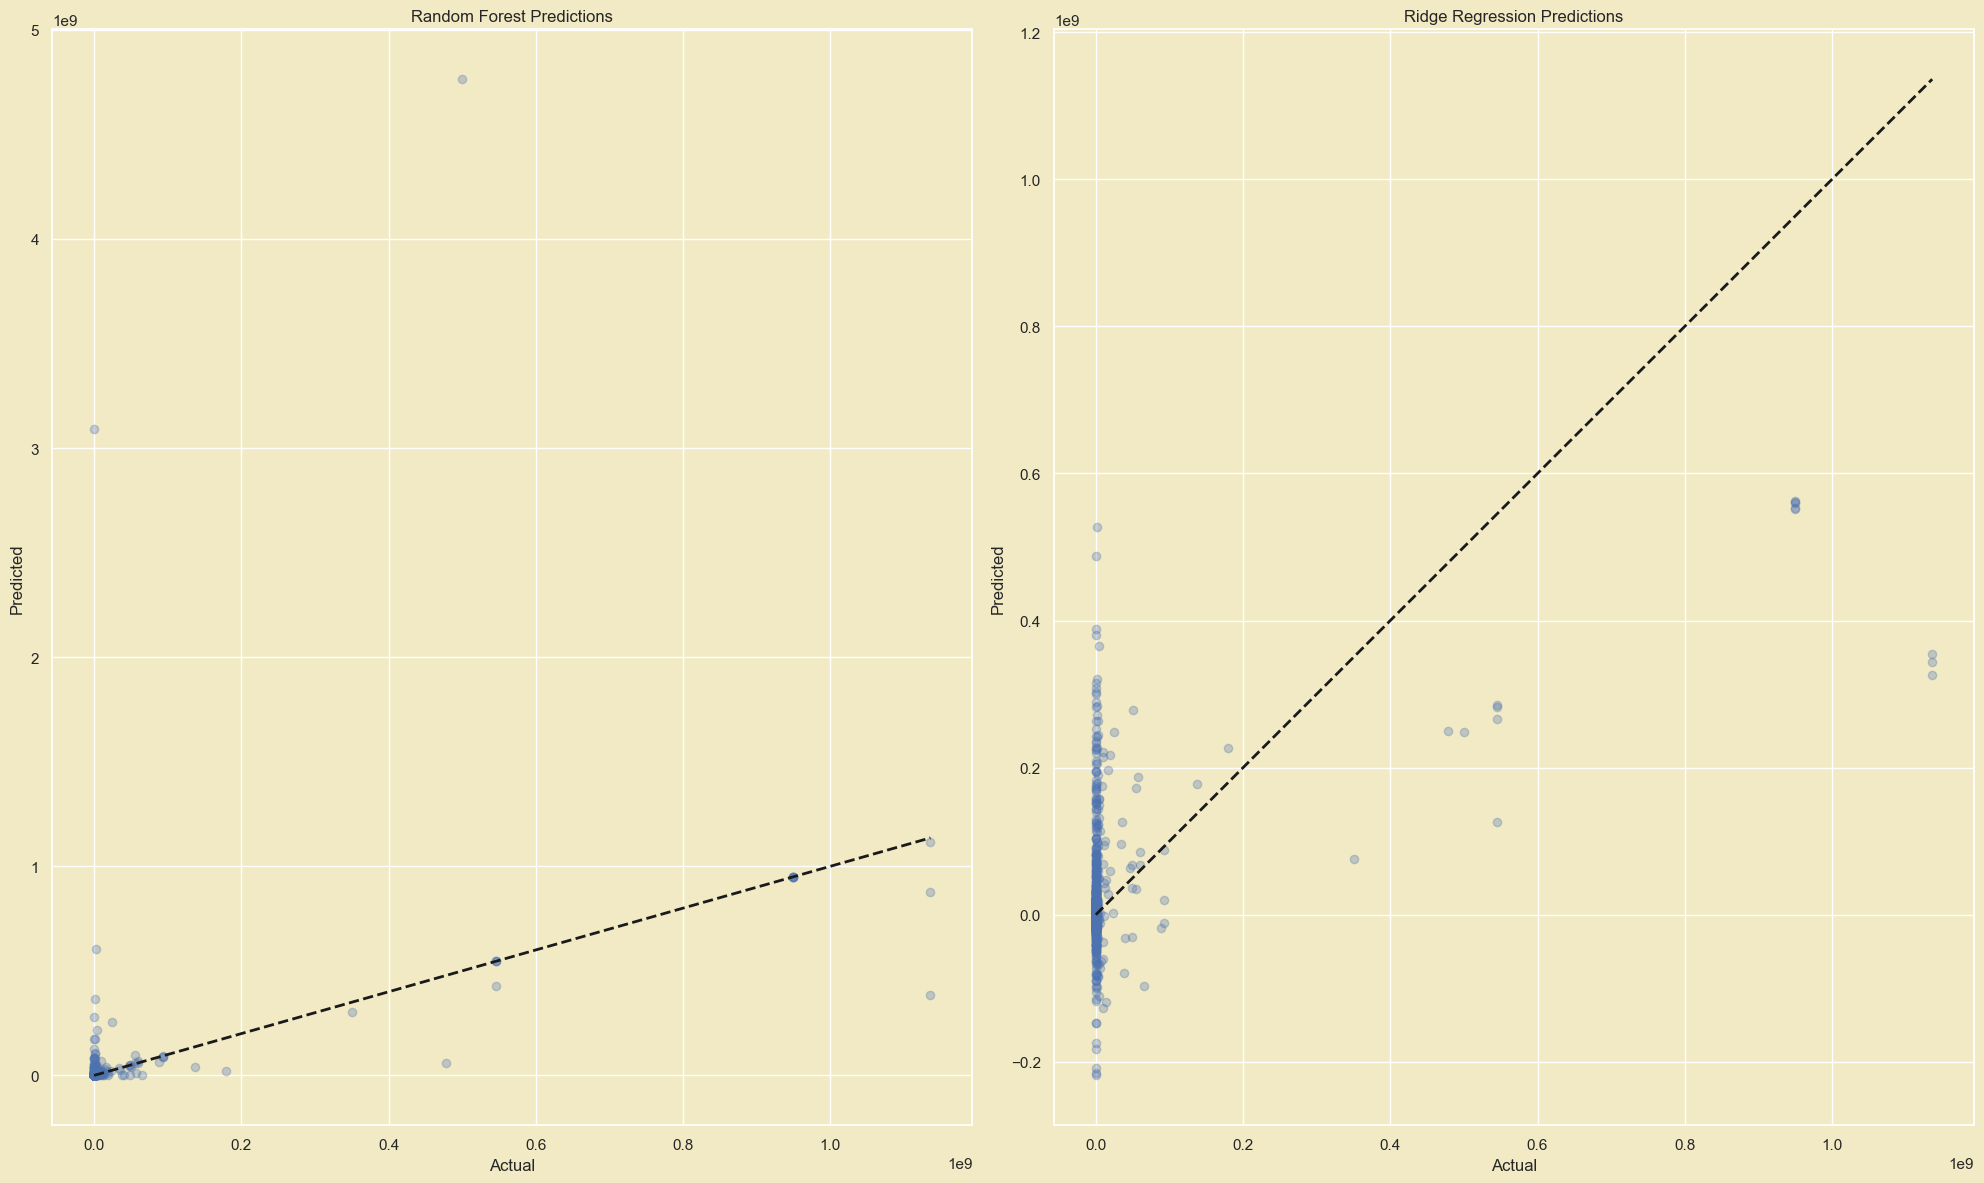

In [711]:
# Plot the results
plt.figure(figsize=(20, 12))

plt.subplot(1, 2, 1)
plt.scatter(y_test, rf_predictions, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Random Forest Predictions')

plt.subplot(1, 2, 2)
plt.scatter(y_test, ridge_predictions, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Ridge Regression Predictions')

plt.tight_layout()
plt.show()